In [1]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset import get_rays
from rendering import rendering
from model import Voxels, Nerf
from ml_helpers import training

from skimage.measure import marching_cubes
import trimesh
import trimesh.smoothing
import os

In [2]:
print("torch version: ", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
else: 
    device = torch.device("cpu")

print("device: ", device)

torch version:  2.5.1
device:  mps


In [5]:
import numpy as np
from pathlib import Path
import quaternion  # You'll need to install numpy-quaternion package
import os

def read_cameras(path):
    """Read COLMAP cameras.txt and convert to intrinsic matrices"""
    cameras = {}
    with open(path, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        if line[0] == '#' or len(line.strip()) == 0:
            continue
        
        data = line.strip().split()
        camera_id = int(data[0])
        # SIMPLE_RADIAL format: f, cx, cy, k
        if data[1] == 'SIMPLE_RADIAL':
            f = float(data[4])
            cx = float(data[5])
            cy = float(data[6])
            
            # Create 4x4 intrinsic matrix
            K = np.array([
                [f, 0, cx, 0],
                [0, f, cy, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]
            ], dtype=np.float32)
            
            cameras[camera_id] = K
            
    return cameras

def read_images(path):
    """Read COLMAP images.txt and convert quaternions to transformation matrices"""
    images = {}
    image_names = {}  # Store image names
    
    with open(path, 'r') as f:
        lines = f.readlines()
        
    i = 0
    while i < len(lines):
        if lines[i][0] == '#' or len(lines[i].strip()) == 0:
            i += 1
            continue
            
        # First line contains pose info
        data = lines[i].strip().split()
        image_id = int(data[0])
        qw, qx, qy, qz = map(float, data[1:5])
        tx, ty, tz = map(float, data[5:8])
        camera_id = int(data[8])
        image_name = data[9]  # Get the image name
        
        # Convert quaternion to rotation matrix
        q = np.quaternion(qw, qx, qy, qz)
        R = quaternion.as_rotation_matrix(q)
        
        # Create 4x4 transformation matrix
        T = np.eye(4, dtype=np.float32)
        T[:3, :3] = R
        T[:3, 3] = [tx, ty, tz]
        
        images[image_id] = {'transform': T, 'camera_id': camera_id}
        image_names[image_id] = image_name
        
        # Skip second line (2D points)
        i += 2
        
    return images, image_names

def save_matrix(matrix, output_path):
    """Save 4x4 matrix to txt file in row-major order"""
    np.savetxt(output_path, matrix.reshape(-1), fmt='%.16f')

def convert_colmap_to_matrices(colmap_dir, output_dir, images_dir):
    """Convert COLMAP output to individual matrix files"""
    colmap_dir = Path(colmap_dir)
    output_dir = Path(output_dir)
    images_dir = Path(images_dir)
    output_dir.mkdir(exist_ok=True)
    
    # Read camera and image data
    cameras = read_cameras(colmap_dir / 'cameras.txt')
    images, image_names = read_images(colmap_dir / 'images.txt')
    
    # Get list of actual image files
    actual_images = set(os.path.splitext(f)[0] for f in os.listdir(images_dir) 
                       if f.lower().endswith(('.png', '.jpg', '.jpeg')))
    
    # Save matrices only for existing images
    processed_count = 0
    for image_id, image_data in images.items():
        image_name = os.path.splitext(image_names[image_id])[0]
        
        # Only process if the image actually exists
        if image_name in actual_images:
            camera_id = image_data['camera_id']
            if camera_id in cameras:
                base_name = f'{processed_count:03d}'
                
                # Save camera intrinsics
                intrinsics_path = output_dir / f'intrinsics_{base_name}.txt'
                save_matrix(cameras[camera_id], intrinsics_path)
                
                # Save camera pose
                pose_path = output_dir / f'pose_{base_name}.txt'
                save_matrix(image_data['transform'], pose_path)
                
                processed_count += 1
    
    print(f"Processed {processed_count} images")
    print(f"Created {processed_count} intrinsics files and {processed_count} pose files")

if __name__ == '__main__':
    # Example usage
    colmap_dir = 'fox/colmap'  # Directory containing cameras.txt and images.txt
    output_dir = 'fox/colmap/matrices'  # Output directory for matrix files
    images_dir = 'fox/imgs'  # Directory containing the actual images
    convert_colmap_to_matrices(colmap_dir, output_dir, images_dir)

Processed 100 images
Created 100 intrinsics files and 100 pose files


In [6]:
import os
import shutil
import random
from pathlib import Path

def read_colmap_image_list(images_txt_path):
    """
    Read COLMAP's images.txt to get the mapping between image names and their IDs
    
    Returns:
        dict: Mapping of image filenames to their COLMAP IDs
    """
    image_map = {}
    
    with open(images_txt_path, 'r') as f:
        lines = f.readlines()
    
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        
        # Skip comments and empty lines
        if line.startswith('#') or not line:
            i += 1
            continue
        
        # Parse image data line
        data = line.split()
        if len(data) >= 10:  # Make sure line has enough elements
            image_id = int(data[0])
            image_name = data[9]  # Image filename is the 10th element
            image_map[image_name] = image_id
        
        # Skip points2D line
        i += 2
    
    return image_map

def split_and_reorganize_dataset(
    base_dir,
    images_dir,
    matrices_dir,
    colmap_dir,
    num_test_images=10,
    image_extensions=('.jpg', '.png', '.jpeg')
):
    """
    Split dataset and organize according to the specified directory structure.
    
    Args:
        base_dir (str): Base directory for the entire dataset
        images_dir (str): Directory containing the original images
        matrices_dir (str): Directory containing pose and intrinsics files
        colmap_dir (str): Directory containing COLMAP output (images.txt)
        num_test_images (int): Number of images to extract as test set
        image_extensions (tuple): Valid image file extensions to consider
    """
    # Convert paths to Path objects
    base_dir = Path(base_dir)
    images_dir = Path(images_dir)
    matrices_dir = Path(matrices_dir)
    colmap_dir = Path(colmap_dir)
    
    # Create directory structure
    imgs_dir = base_dir / 'imgs'
    test_dir = base_dir / 'test'
    train_dir = base_dir / 'train'
    
    test_intrinsics_dir = test_dir / 'intrinsics'
    test_pose_dir = test_dir / 'pose'
    train_intrinsics_dir = train_dir / 'intrinsics'
    train_pose_dir = train_dir / 'pose'
    
    for dir_path in [imgs_dir, test_intrinsics_dir, test_pose_dir, 
                    train_intrinsics_dir, train_pose_dir]:
        dir_path.mkdir(parents=True, exist_ok=True)
    
    # Read COLMAP's image list to get proper image-to-ID mapping
    colmap_image_map = read_colmap_image_list(colmap_dir / 'images.txt')
    
    # Get list of all images that are in both the image directory and COLMAP's mapping
    image_files = [
        f for f in os.listdir(images_dir)
        if f.lower().endswith(image_extensions) and f in colmap_image_map
    ]
    
    if len(image_files) < num_test_images:
        raise ValueError(f"Not enough valid images. Found {len(image_files)}, requested {num_test_images}")
    
    # Randomly select test images
    test_images = set(random.sample(image_files, num_test_images))
    train_images = set(image_files) - test_images
    
    # Process test set
    for i, image_file in enumerate(sorted(test_images)):
        # Get COLMAP ID for this image
        colmap_id = colmap_image_map[image_file]
        colmap_id_str = f"{colmap_id:03d}"
        
        # Generate new filenames
        image_extension = os.path.splitext(image_file)[1]
        new_name = f"test_{i}"
        
        # Move and rename image
        shutil.copy2(
            images_dir / image_file,
            imgs_dir / f"{new_name}{image_extension}"
        )
        os.remove(images_dir / image_file)
        
        # Move and rename corresponding pose and intrinsics files
        source_intrinsics = matrices_dir / f"intrinsics_{colmap_id_str}.txt"
        source_pose = matrices_dir / f"pose_{colmap_id_str}.txt"
        
        if source_intrinsics.exists():
            shutil.copy2(source_intrinsics, test_intrinsics_dir / f"{new_name}.txt")
            os.remove(source_intrinsics)
        else:
            print(f"Warning: Missing intrinsics file for test image {i}")
            
        if source_pose.exists():
            shutil.copy2(source_pose, test_pose_dir / f"{new_name}.txt")
            os.remove(source_pose)
        else:
            print(f"Warning: Missing pose file for test image {i}")
    
    # Process train set
    for i, image_file in enumerate(sorted(train_images)):
        # Get COLMAP ID for this image
        colmap_id = colmap_image_map[image_file]
        colmap_id_str = f"{colmap_id:03d}"
        
        # Generate new filenames
        image_extension = os.path.splitext(image_file)[1]
        new_name = f"train_{i}"
        
        # Move and rename image
        shutil.copy2(
            images_dir / image_file,
            imgs_dir / f"{new_name}{image_extension}"
        )
        os.remove(images_dir / image_file)
        
        # Move and rename corresponding pose and intrinsics files
        source_intrinsics = matrices_dir / f"intrinsics_{colmap_id_str}.txt"
        source_pose = matrices_dir / f"pose_{colmap_id_str}.txt"
        
        if source_intrinsics.exists():
            shutil.copy2(source_intrinsics, train_intrinsics_dir / f"{new_name}.txt")
            os.remove(source_intrinsics)
        else:
            print(f"Warning: Missing intrinsics file for train image {i}")
            
        if source_pose.exists():
            shutil.copy2(source_pose, train_pose_dir / f"{new_name}.txt")
            os.remove(source_pose)
        else:
            print(f"Warning: Missing pose file for train image {i}")
    
    print(f"Successfully split and reorganized dataset:")
    print(f"Test set: {len(test_images)} images")
    print(f"Train set: {len(train_images)} images")
    print(f"\nDirectory structure created:")
    print(f"Images: {imgs_dir}")
    print(f"Test intrinsics: {test_intrinsics_dir}")
    print(f"Test poses: {test_pose_dir}")
    print(f"Train intrinsics: {train_intrinsics_dir}")
    print(f"Train poses: {train_pose_dir}")

if __name__ == '__main__':
    # Example usage
    base_dir = 'fox'  # Base directory for the entire dataset
    images_dir = 'fox/imgs'  # Directory containing original images
    matrices_dir = 'fox/colmap/matrices'  # Directory containing pose and intrinsics files
    colmap_dir = 'fox/colmap'  # Directory containing COLMAP's images.txt
    
    split_and_reorganize_dataset(
        base_dir=base_dir,
        images_dir=images_dir,
        matrices_dir=matrices_dir,
        colmap_dir=colmap_dir,
        num_test_images=10
    )

Successfully split and reorganized dataset:
Test set: 10 images
Train set: 90 images

Directory structure created:
Images: fox/imgs
Test intrinsics: fox/test/intrinsics
Test poses: fox/test/pose
Train intrinsics: fox/train/intrinsics
Train poses: fox/train/pose


# Camera / Dataset

In [7]:
batch_size = 1024

o, d, target_px_values = get_rays('fox', mode='train')
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(d).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)


dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(d).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(target_px_values).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)


test_o, test_d, test_target_px_values = get_rays('fox', mode='test')

# Training

100%|███████████████████████████████████████| 3516/3516 [10:38<00:00,  5.51it/s]


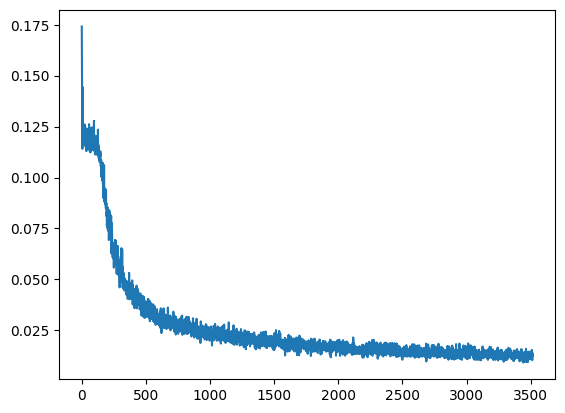

100%|█████████████████████████████████████| 14063/14063 [42:34<00:00,  5.50it/s]


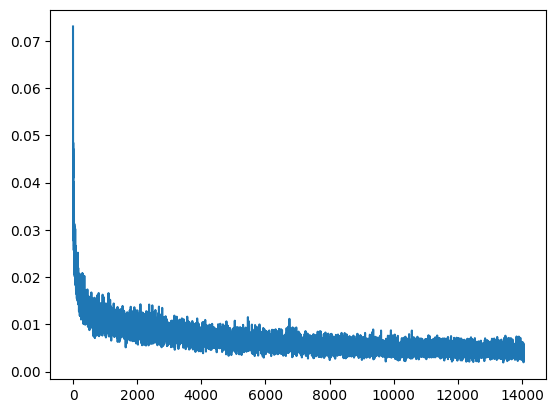

In [8]:
device = device

tn = 8.
tf = 12.
nb_epochs = 1 #15 30
lr =  1e-3 # 1e-3 5e-4
gamma = .5 #0.5 0.7 
nb_bins = 100 #100 256

model = Nerf(hidden_dim=256).to(device) #Nerf(hidden_dim=128).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)



training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device=device)
plt.plot(training_loss)
plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)
plt.plot(training_loss)
plt.show()

In [9]:
torch.save(model, 'model_nerf_colmap')

# Mesh extraction

In [10]:
model = torch.load('model_nerf_colmap').to(device)

/var/folders/wv/_x9hjmys03x5gnbfl70ry2sr0000gn/T/ipykernel_29958/2503494064.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model_nerf_colmap').to(de

In [11]:
import torch
import numpy as np
from skimage.measure import marching_cubes
import trimesh
import torch.nn.functional as F

def analyze_density_field(density_volume):
    """Analyze the density field to help choose a good threshold."""
    min_density = float(density_volume.min())
    max_density = float(density_volume.max())
    mean_density = float(density_volume.mean())
    std_density = float(density_volume.std())
    
    print(f"Density field statistics:")
    print(f"Min: {min_density:.6f}")
    print(f"Max: {max_density:.6f}")
    print(f"Mean: {mean_density:.6f}")
    print(f"Std: {std_density:.6f}")
    
    # Suggest threshold as mean + 1 std deviation
    suggested_threshold = mean_density + std_density
    return suggested_threshold

def extract_mesh(nerf_model, resolution=128, threshold=None, bbox_min=[-1.5, -1.5, -1.5], 
                bbox_max=[1.5, 1.5, 1.5], device=torch.device("cpu")):
    """
    Extract a colored mesh from a trained NeRF model.
    
    Args:
        nerf_model: Trained NeRF model
        resolution: Grid resolution for marching cubes
        threshold: Density threshold for surface extraction (if None, will be auto-determined)
        bbox_min: Minimum corner of bounding box
        bbox_max: Maximum corner of bounding box
        device: Torch device to use
    
    Returns:
        trimesh.Trimesh: Colored mesh
    """
    print(f"Creating density volume with resolution {resolution}...")
    
    # Create grid of points
    x = torch.linspace(bbox_min[0], bbox_max[0], resolution)
    y = torch.linspace(bbox_min[1], bbox_max[1], resolution)
    z = torch.linspace(bbox_min[2], bbox_max[2], resolution)
    xx, yy, zz = torch.meshgrid(x, y, z, indexing='ij')
    points = torch.stack([xx, yy, zz], dim=-1).to(device)
    
    # Create density volume
    density_volume = torch.zeros((resolution, resolution, resolution))
    chunk_size = 512 * 512  # Process in chunks to avoid OOM
    
    print("Sampling density field...")
    with torch.no_grad():
        for i in range(0, points.numel() // 3, chunk_size):
            chunk_points = points.reshape(-1, 3)[i:i+chunk_size]
            # Assume model returns (rgb, sigma) tuple
            _, chunk_densities = nerf_model(chunk_points, torch.zeros_like(chunk_points))
            density_volume.reshape(-1)[i:i+chunk_size] = chunk_densities.cpu()
    
    # Auto-determine threshold if not provided
    if threshold is None:
        threshold = analyze_density_field(density_volume)
        print(f"Auto-determined threshold: {threshold:.6f}")
    
    print(f"Extracting mesh with threshold {threshold}...")
    
    try:
        # Extract mesh using marching cubes
        vertices, faces, normals, _ = marching_cubes(
            density_volume.numpy(),
            threshold,
            spacing=((bbox_max[0] - bbox_min[0])/resolution,
                    (bbox_max[1] - bbox_min[1])/resolution,
                    (bbox_max[2] - bbox_min[2])/resolution)
        )
    except ValueError as e:
        print("Error during marching cubes:")
        print(e)
        print("\nTry adjusting the threshold based on the density statistics above.")
        raise
    
    print(f"Mesh extracted with {len(vertices)} vertices and {len(faces)} faces")
    
    # Adjust vertices to match bbox
    vertices = vertices + np.array(bbox_min)
    
    # Sample colors at vertex positions
    vertex_colors = torch.zeros((len(vertices), 3))
    vertices_tensor = torch.tensor(vertices, dtype=torch.float32).to(device)
    
    print("Sampling colors...")
    with torch.no_grad():
        for i in range(0, len(vertices), chunk_size):
            chunk_vertices = vertices_tensor[i:i+chunk_size]
            # Assume model returns (rgb, sigma) tuple
            chunk_colors, _ = nerf_model(chunk_vertices, torch.zeros_like(chunk_vertices))
            vertex_colors[i:i+chunk_size] = chunk_colors.cpu()
    
    # Create mesh with vertex colors
    mesh = trimesh.Trimesh(
        vertices=vertices,
        faces=faces,
        vertex_colors=(vertex_colors.numpy() * 255).astype(np.uint8),
        vertex_normals=normals
    )
    
    return mesh

def save_colored_mesh(nerf_model, output_path, resolution=256, threshold=None, device=torch.device("cpu")):
    """
    Extract and save a colored mesh from a NeRF model.
    
    Args:
        nerf_model: Trained NeRF model
        output_path: Path to save the mesh (should end in .ply or .obj)
        resolution: Resolution for marching cubes
        threshold: Density threshold (if None, will be auto-determined)
        device: Torch device to use
    """
    mesh = extract_mesh(nerf_model, resolution=resolution, threshold=threshold, device=device)
    
    print("Processing mesh...")
    # Optional mesh cleanup
    mesh = mesh.process(validate=True)
    
    print(f"Saving mesh to {output_path}...")
    # Save the mesh
    mesh.export(output_path)
    return mesh

# After loading your model
resolution = 700  # Increase for better quality, decrease if you run into memory issues
output_path = "nerf_mesh.obj"  # Can also use .obj format

# Extract and save the mesh
mesh = save_colored_mesh(model, output_path, resolution=resolution, device=device)

Creating density volume with resolution 700...
Sampling density field...
Density field statistics:
Min: 0.000000
Max: 556.569885
Mean: 49.355793
Std: 48.118290
Auto-determined threshold: 97.474083
Extracting mesh with threshold 97.47408294677734...
Mesh extracted with 20426423 vertices and 40741980 faces
Sampling colors...
Processing mesh...
Saving mesh to nerf_mesh.obj...


In [ ]:
#!pip install Pymcubes
#!pip install trimesh
#!pip install -U scikit-image
#!pip install genesis-world  # Requires Python >=3.9;
#!pip uninstall genesis-world
#!conda install -c anaconda trimesh